# Album Art Generation

## Imports

In [1]:
import cv2
import librosa
import librosa.display
from matplotlib import pyplot as plt
import numpy as np
import os
import PIL
import pydub
import random
from scipy import signal
from IPython.display import display, Audio, Image
import warnings

# neural network example
from keras.models import Sequential
from keras.layers import Dense

## Helper Functions

In [2]:
# display audio and album art for given song (mp3)
def display_song(music_folder, filename):
    display(Audio(filename=get_song_path(music_folder, filename)))
    display(Image(filename=get_artwork_path(music_folder, filename)))
    
# display audio for given song (numpy)
def display_song_np(arr, fs):
    display(Audio(data=arr, rate=fs))
    
# display image for given song (numpy)
def display_artwork_np(arr):
    display(PIL.Image.fromarray(arr))
    
def mp3_to_np(f, normalized=False):
    """MP3 to numpy array"""
    a = pydub.AudioSegment.from_mp3(f)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2:
        y = y.reshape((-1, 2))
    if normalized:
        return a.frame_rate, np.float32(y) / 2**15
    else:
        return a.frame_rate, y
    
def get_artwork_path(music_folder, filename):
    return f"{music_folder}/artwork/{filename}.jpg"

def get_song_path(music_folder, filename):
    return f"{music_folder}/{filename}.mp3"

def stft(
    s,
    sf=256,
    nperseg=256,
    window="hann",
    noverlap=256 - 1,
    boundary=None,
    axis=-1
):
    if boundary is None:
        padded = False
    else:
        padded = True
    f, t, Zxx = signal.stft(
        s,
        sf,
        nperseg=nperseg,
        window=window,
        noverlap=noverlap,
        boundary=boundary,
        padded=padded,
        axis=axis,
    )
    return f, t, np.abs(Zxx)

## Display Random

Sunset Lover_Petit Biscuit


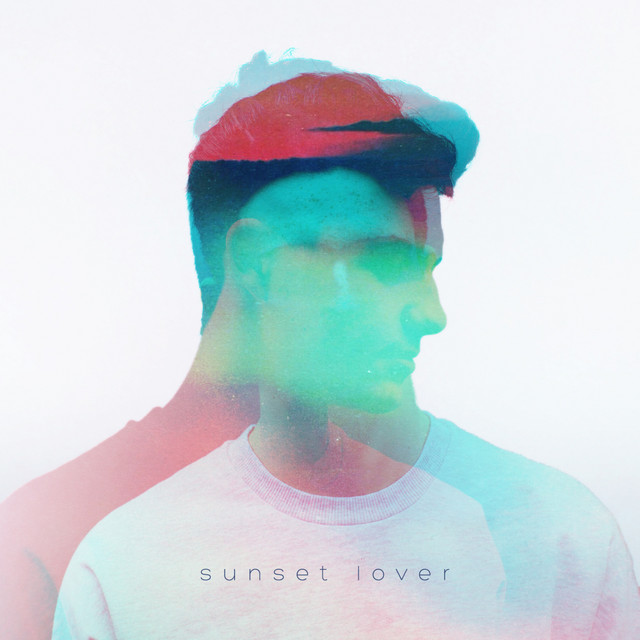

In [4]:
music_folder = "../spotify_downloader/music/likes-samples"
song_list = []
_, _, song_list = next(os.walk(music_folder), (None, None, []))
song_list = [s.split('.mp3')[0] for s in song_list if ".mp3" in s]

song = random.choice(song_list)
print(song)

display_song(music_folder, song)

## Load Song to NumPy

/Users/sabard/.envs/album-gen/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


22050
(662077,)


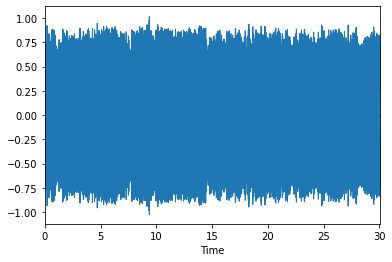

In [5]:
# full sampling frequency, stereo
# fr, song_data = mp3_to_np(get_song_path(music_folder, song))

# https://librosa.org/doc/latest/generated/librosa.load.html#librosa.load
# 22050 sampling frequency, mono
song_data, fs = librosa.load(get_song_path(music_folder, song), sr=22050)
print(fs)
print(song_data.shape)

display_song_np(song_data, fs)

librosa.display.waveplot(song_data, sr=fs)

Tempo: 83.35433467741936.
Beat times: [ 0.09287982  0.83591837  1.67183673  2.39165533  3.20435374  3.92417234
  4.73687075  5.50312925  6.31582766  7.03564626  7.80190476  8.59138322
  9.33442177 10.12390023 10.93659864 11.67963719 12.4923356  13.23537415
 13.95519274 14.76789116 15.55736961 16.32362812 17.11310658 17.87936508
 18.69206349 19.41188209 20.17814059 20.96761905 21.78031746 22.50013605
 23.26639456 24.05587302 24.82213152 25.61160998 26.37786848 27.14412698
 27.9568254 ]
(129,)
(5171,)
(129, 5171)
(1025, 1294)


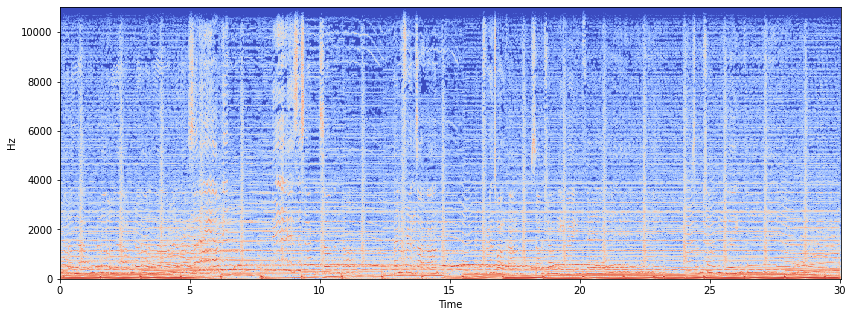

In [6]:
tempo, beat_frames = librosa.beat.beat_track(y=song_data, sr=fs)
beat_times = librosa.frames_to_time(beat_frames, sr=fs)
print(f"Tempo: {tempo}.\nBeat times: {beat_times}")

f, t, Z = stft(song_data,
    sf=fs,
    nperseg=256,
    window="hann",
    noverlap=128,#256 - 1,
    boundary=None,
    axis=-1)

print(f.shape)
print(t.shape)
print(Z.shape)

X = librosa.stft(song_data)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=fs, x_axis='time', y_axis='hz')

print(Xdb.shape)

## Training and Test Set Creation

In [7]:
set_created = os.path.exists("data/x.npy") and os.path.exists("data/y.npy")
if not set_created:
    x = []
    y = []
    warnings.filterwarnings('ignore')
    for song in song_list:
        song_data, fs = librosa.load(get_song_path(music_folder, song), sr=22050)
        X = librosa.stft(song_data)
        Xdb = librosa.amplitude_to_db(abs(X))
        x.append(Xdb)

        image_data = cv2.imread(get_artwork_path(music_folder, song))
        image_data = cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)
        if image_data.shape != (640 , 640, 3):
            image_data = cv2.resize(image_data, (640, 640))
        y.append(image_data)
    x = np.array(x)
    y = np.array(y)
    print(x.shape)
    print(y.shape)
    np.save("data/x.npy", x)
    np.save("data/y.npy", y)
else:
    x = np.load("data/x.npy")
    y = np.load("data/y.npy")
    x_square = []
    x_sq_smol = []
    sq_pix = 640
    sq_smol_pix = 160
    sq_fs = fs*sq_pix/x[0].shape[1]
    for rectangle in x:
        square = cv2.resize(rectangle, dsize=(sq_pix, sq_pix), interpolation=cv2.INTER_CUBIC)
        x_square.append(square)
        x_sq_smol.append(cv2.resize(square, dsize=(sq_smol_pix, sq_smol_pix), interpolation=cv2.INTER_CUBIC))
    x_square = np.array(x_square)
    x_sq_smol = np.array(x_sq_smol)
    y_grey = []
    y_gr_smol = []
    y_smol = []
    for color in y:
        y_smol.append(cv2.resize(color, dsize=(sq_smol_pix, sq_smol_pix), interpolation=cv2.INTER_CUBIC))
        grey = cv2.cvtColor(color, cv2.COLOR_BGR2GRAY)
        y_grey.append(grey) 
        y_gr_smol.append(cv2.resize(grey, dsize=(sq_smol_pix, sq_smol_pix), interpolation=cv2.INTER_CUBIC))
    y_grey = np.array(y_grey)
    y_gr_smol = np.array(y_gr_smol)
    y_smol = np.array(y_smol)

In [8]:
print(x.shape)
print(y.shape)
print(x_square.shape)
print(y_grey.shape)
print(x_sq_smol.shape)
print(y_gr_smol.shape)
print(y_smol.shape)

(96, 1025, 1294)
(96, 640, 640, 3)
(96, 640, 640)
(96, 640, 640)
(96, 160, 160)
(96, 160, 160)
(96, 160, 160, 3)


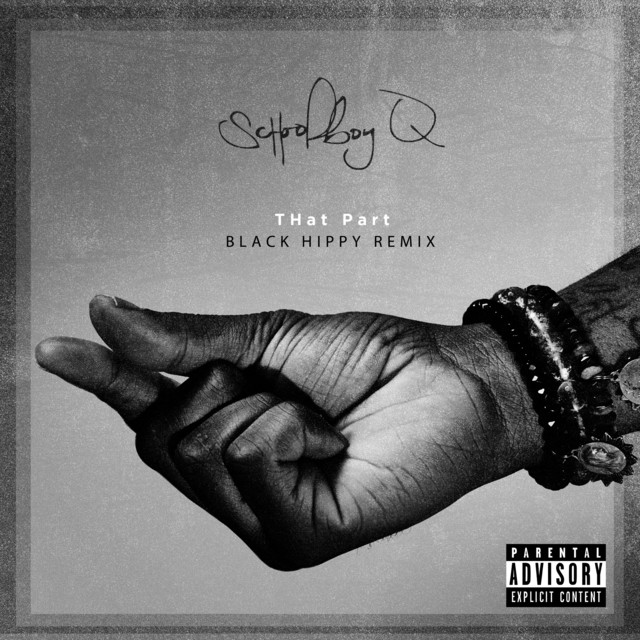

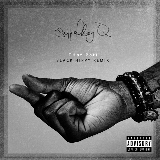

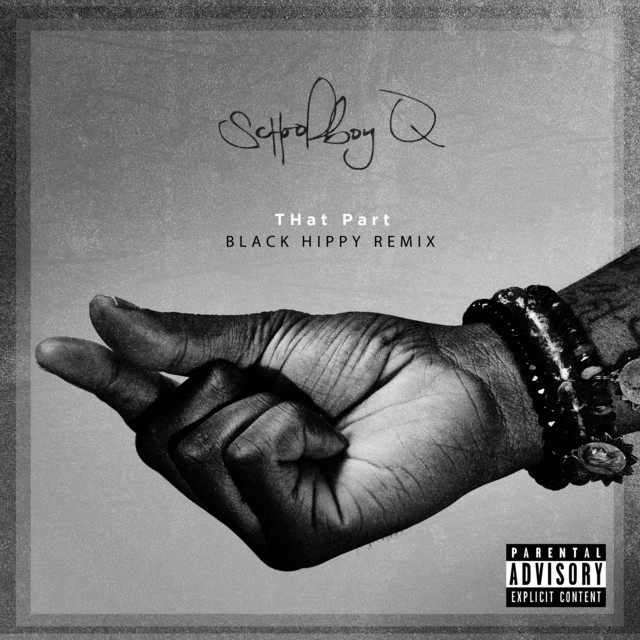

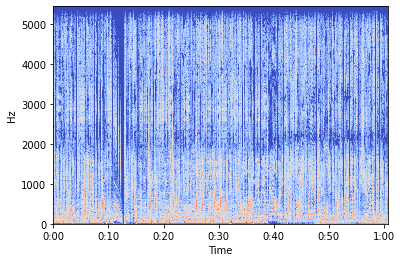

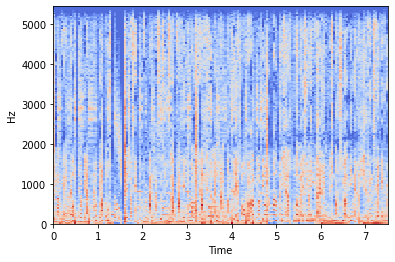

In [92]:
def display_datum(spectral, album_art):
    librosa.display.specshow(spectral, sr=sq_fs, x_axis='time', y_axis='hz')
    display_artwork_np(album_art)
                       
i = 0
display_datum(x[i], y[i])
plt.figure()
display_datum(x_sq_smol[i], y_gr_smol[i])
display_song(music_folder, song)

## Linear Regression

### greyscale

In [181]:

# create train and test sets for greyscale
train_pct = 0.9
assert len(x_square) == len(y_grey)
cutoff = int(len(x_square) * train_pct)
x_train = x_sq_smol[:cutoff]
x_test = x_sq_smol[cutoff+1:]
y_train = y_gr_smol[:cutoff]
y_test = y_gr_smol[cutoff+1:]

 # flatten
x_train_flat = np.reshape(x_train, (86, sq_smol_pix*sq_smol_pix))
y_train_flat = np.reshape(y_train, (86, sq_smol_pix*sq_smol_pix))
print(x_train_flat.shape)
print(y_train_flat.shape)

def create_greyscale_A(load=True):
    if load and os.path.exists("data/A_grey.npy"):
        return np.load("data/A_grey.npy")
    if load:
        print("No A_grey found, generating...")

    # compute A
    x_train_flat_inv = np.linalg.pinv(x_train_flat)
    A_grey = np.dot(x_train_flat_inv, y_train_flat)

A_grey = create_greyscale_A(load=True)
print(A_grey.shape)

(86, 25600)
(86, 25600)
(25600, 25600)


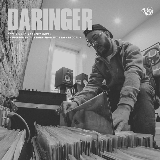

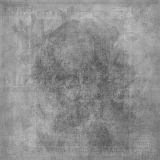

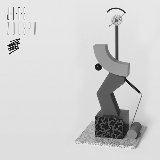

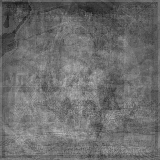

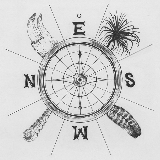

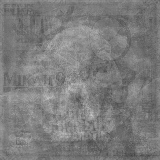

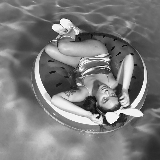

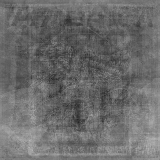

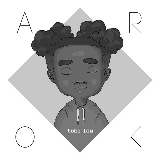

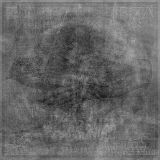

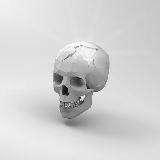

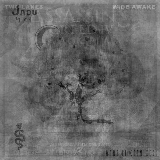

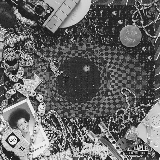

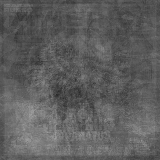

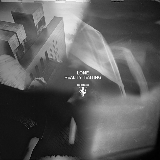

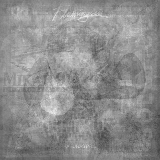

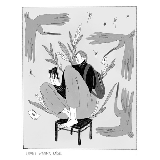

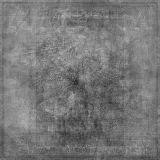

In [205]:
def gen_grey_album_art(spec, convert_PIL=True):
    im_size = sq_smol_pix*sq_smol_pix
    im_shape = (sq_smol_pix, sq_smol_pix)
#     librosa.display.specshow(spec, sr=sq_fs, x_axis='time', y_axis='hz')
    Y_img = spec.reshape(im_size).dot(A_grey).reshape(im_shape)
#     Y_img = np.uint8(Y_img + Y_img.min() / Y_img.max() * 255.)
    Y_img = PIL.Image.fromarray(Y_img)
    Y_img = Y_img.convert("L")
    if not convert_PIL:
        Y_img = np.array(Y_img, dtype=np.uint8)
    return Y_img

for i in range(9):
    Y_img = gen_grey_album_art(x_test[i])
    display_artwork_np(y_test[i])
    # display_artwork_np(Y)
    display(Y_img)

In [12]:
np.save("data/A_grey.npy", A_grey)

### color

In [178]:
train_pct = 0.9
assert len(x_square) == len(y_smol)
cutoff = int(len(x_square) * train_pct)
x_train = x_sq_smol[:cutoff]
x_test = x_sq_smol[cutoff+1:]
y_train = y_smol[:cutoff]
y_test = y_smol[cutoff+1:]

x_train_flat = np.reshape(x_train, (86, sq_smol_pix*sq_smol_pix))
# y_train_flat = np.reshape(y_train, (86, sq_smol_pix*sq_smol_pix * 3))
y_train_flat_R = np.reshape(y_train[:,:,:,0], (86, sq_smol_pix*sq_smol_pix))
y_train_flat_G = np.reshape(y_train[:,:,:,1], (86, sq_smol_pix*sq_smol_pix))
y_train_flat_B = np.reshape(y_train[:,:,:,2], (86, sq_smol_pix*sq_smol_pix))
                            

print(x_train_flat.shape)
print(y_train_flat.shape)
x_train_flat_inv = np.linalg.pinv(x_train_flat)
# A_color = np.dot(x_train_flat_inv, y_train_flat)
A_color_R = np.dot(x_train_flat_inv, y_train_flat_R)
A_color_G = np.dot(x_train_flat_inv, y_train_flat_G)
A_color_B = np.dot(x_train_flat_inv, y_train_flat_B)
# print(A_color.shape)

58.69368


In [173]:
# A_color = A_color.reshape((A_color.shape[0], -1, 3))
print(A_color_R.dtype)

float64


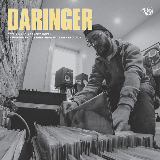

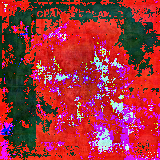

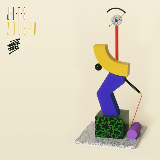

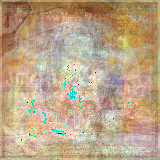

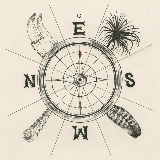

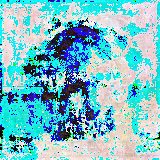

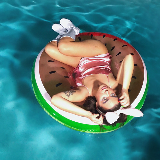

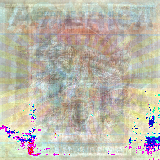

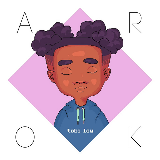

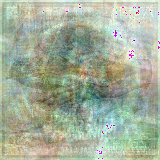

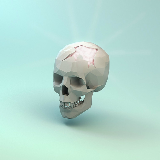

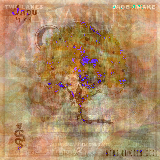

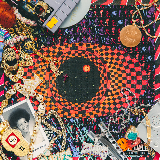

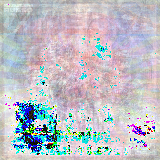

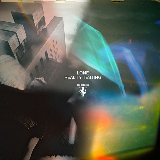

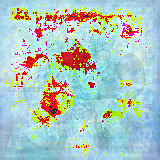

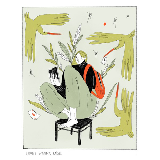

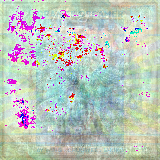

In [66]:
def gen_color_album_art(spec, convert_PIL=True):
    x_size = sq_smol_pix*sq_smol_pix
    im_size = sq_smol_pix*sq_smol_pix*3
    im_shape = (sq_smol_pix, sq_smol_pix, 3)
#     librosa.display.specshow(spec, sr=sq_fs, x_axis='time', y_axis='hz')
    Y_R = spec.reshape(x_size).dot(A_color_R).reshape((sq_smol_pix, sq_smol_pix))
    Y_R = np.uint8((Y_R + np.min(Y_R)) / np.max(Y_R) * 255.)
    Y_G = spec.reshape(x_size).dot(A_color_G).reshape((sq_smol_pix, sq_smol_pix))
    Y_G = np.uint8((Y_G + np.min(Y_G)) / np.max(Y_G) * 255.)
    Y_B = spec.reshape(x_size).dot(A_color_B).reshape((sq_smol_pix, sq_smol_pix))
    Y_B = np.uint8((Y_B + np.min(Y_B)) / np.max(Y_B) * 255.)
    Y = np.dstack((Y_R, Y_G, Y_B))
#     Y = spec.reshape(x_size).dot(A_color).reshape((sq_smol_pix, sq_smol_pix, 3))
    # scale Y values to 0..255
#     for i in range(Y.shape[-1]):
#         Y_i = Y[:, :, i]
#         Y_i = (Y_i + np.min(Y_i)) / np.max(Y_i) * 255.
#         Y[:, :, i] = Y_i
#     Y = np.uint8(Y)
    if convert_PIL:
        return PIL.Image.fromarray(Y)
    else: 
        return Y
    
    
for i in range(len(x_test)):
    Y = gen_color_album_art(x_test[i])
    display_artwork_np(y_test[i])
    display(Y)

## Simple Neural Net

In [ ]:
# define the keras model
model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

## Video creation

In [30]:
song = song_list[0]
print(song)

song_data, fs = librosa.load(get_song_path(music_folder, song), sr=22050)

THat Part - Black Hippy Remix_ScHoolboy Q


/Users/sabard/.envs/album-gen/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [210]:
sliding_window_size = fs * 10
frame_rate = 24
sliding_window_step = fs // frame_rate

index = 0
squares = []
imgs = []
imgs_grey = []
sq_pix = 160

while index + sliding_window_size < song_data.size:
    sliding_window = song_data[index:index+sliding_window_size]
    
    img = librosa.stft(sliding_window)
    img_db = librosa.amplitude_to_db(abs(img))
    square = cv2.resize(img_db, dsize=(sq_pix, sq_pix), interpolation=cv2.INTER_CUBIC)
    squares.append(square)
    imgs_grey.append(gen_grey_album_art(square, convert_PIL=False))
#     imgs.append(gen_color_album_art(square, convert_PIL=False))
    
    index += sliding_window_step

30
0.0


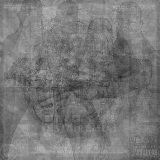

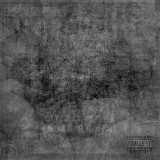

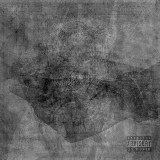

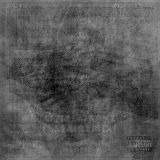

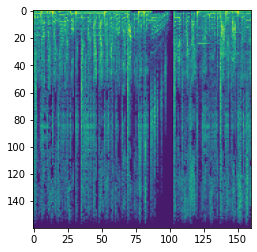

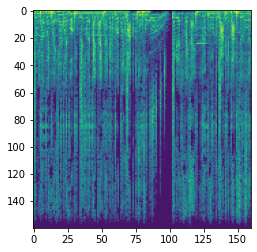

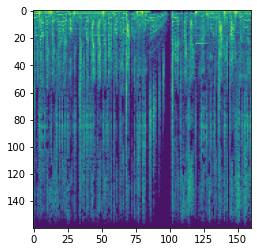

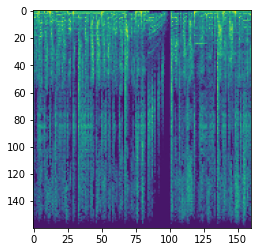

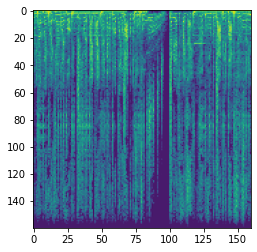

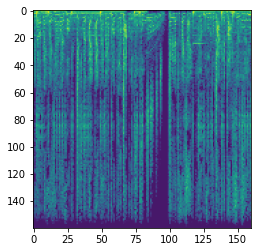

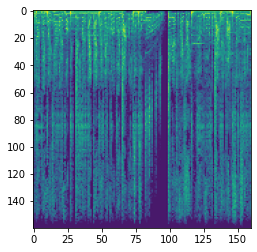

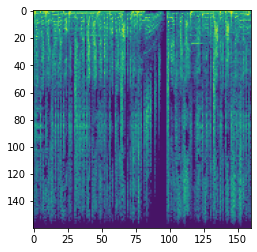

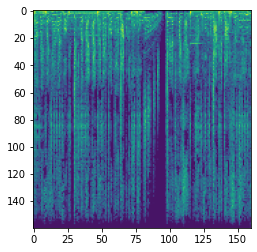

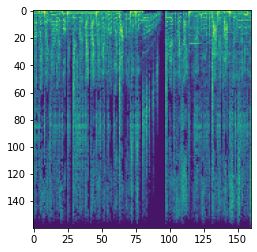

In [207]:
print(len(squares))
for i in range(10):
    plt.figure()
    plt.imshow(squares[i])

print(len(imgs)/frame_rate)

for i in range(4):
#     display_artwork_np(imgs[i])
    display_artwork_np(imgs_grey[i])

In [211]:
# write grey
size = 160, 160
out = cv2.VideoWriter('data/test_video_grey.mp4', cv2.VideoWriter_fourcc(*'mp4v'), frame_rate, (size[1], size[0]), False)
for img in imgs_grey:
    out.write(img)
cv2.destroyAllWindows()
out.release()

In [ ]:
# write color
size = 160, 160
out = cv2.VideoWriter('data/test_video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), frame_rate, (size[1], size[0]), True)
for img in imgs:
    display_artwork_np(img)
    print(img.shape)
    out.write(cv2.cvtColor(img,cv2.COLOR_RGB2BGR))
cv2.destroyAllWindows()
out.release()